<a href="https://colab.research.google.com/github/m0zzarella/Fundus-Imaging/blob/main/fundus_imaging_unet_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio
!pip install albumentations
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/DRIVE_Data/"

/content/drive/MyDrive/DRIVE_Data


In [4]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))   #loading the images
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))  #loading the masks

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    H = 512
    W = 512

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        
        name = x.split("/")[-1].split(".")[0]    #extracts the images
        
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY);
        #kernel = np.ones((5,5), np.uint8)
        #x = cv2.dilate(x, kernel, iterations=1)
         
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            X = [x, x1, x2, x3, x4, x5]
            Y = [y, y1, y2, y3, y4, y5]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(X) == 1:
                tmp_image_name = f"{name}.jpg"
                tmp_mask_name = f"{name}.jpg"
            else:
                tmp_image_name = f"{name}_{index}.jpg"
                tmp_mask_name = f"{name}_{index}.jpg"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

def main():
    np.random.seed(42)  #saves the seed data to reproduce the results 

    data_path = "/content/drive/MyDrive/DRIVE_Data"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

   
    create_dir("new_data/train/image")
    create_dir("new_data/train/mask")
    create_dir("new_data/test/image")
    create_dir("new_data/test/mask")

    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(test_x, test_y, "new_data/test/", augment=False)
    
if __name__ == "__main__":
    
    main()

Train: 20 - 20
Test: 20 - 20


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import math

#defining the loss functions
def iou(y_true, y_pred):  #defining intersection over union
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def cross_entropy(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce(y_true, y_pred)


def cross_loss(y_true, y_pred):
    return 1.0 - cross_entropy(y_true, y_pred)
    
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

    

In [14]:
#defining the u-net monte carlo dropout model
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, MaxPooling2D
from keras.models import Model

drop_rate = 0.5
drop_train = False #monte carlo dropout
#drop_train = True

def conv_block(inputs, num_filters):
    
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def conv_dropout(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = Dropout(drop_rate)(x, training = drop_train)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def encoder_dropout(inputs, num_filters):
    x = conv_dropout(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p
  
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def decoder_dropout(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_dropout(x, num_filters)
    return x
   

def build_unet(input_shape):
    inputs = Input(input_shape)

    e1, p1 = encoder_block(inputs, 32)
    e2, p2 = encoder_block(p1, 64)
    e3, p3 = encoder_dropout(p2, 128)
    e4, p4 = encoder_dropout(p3, 256)

    base1 = conv_dropout(p4, 512)

    d1 = decoder_dropout(base1, e4, 256)
    d2 = decoder_dropout(d1, e3, 128)
    d3 = decoder_block(d2, e2, 64)
    d4 = decoder_block(d3, e1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

def main():
    input_shape = (512, 512, 1)
    model = build_unet(input_shape)
    model.summary()

if __name__ == "__main__":
    main()



Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_106 (Conv2D)            (None, 512, 512, 32  320         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_104 (Batch  (None, 512, 512, 32  128        ['conv2d_106[0][0]']             
 Normalization)                 )                                                              

In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision



H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY);
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)  
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)              ## (512, 512, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 1])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

def main():
    
    np.random.seed(42)
    tf.random.set_seed(42)

    
    create_dir("files")


    batch_size = 2
    lr = 1e-4
    num_epochs = 100
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    #loading the dataset
    dataset_path = "new_data"
    train_path = os.path.join(dataset_path, "train")
    valid_path = os.path.join(dataset_path, "test")

    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

    train_steps = len(train_x)//batch_size
    valid_setps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1
    if len(valid_x) % batch_size != 0:
        valid_setps += 1

    
    model = build_unet((H, W, 1))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[cross_loss, dice_coef, iou,f1_m,precision_m, recall_m])
    # model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_setps,
        callbacks=callbacks
    )
if __name__ == "__main__":
    
    main()



Train: 120 - 120
Valid: 20 - 20
Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 0.7186 - cross_loss: 0.1353 - dice_coef: 0.2814 - iou: 0.1652 - f1_m: 0.3170 - precision_m: 0.2037 - recall_m: 0.8018
Epoch 1: val_loss improved from inf to 0.85170, saving model to files/model.h5
60/60 [==============================] - 32s 231ms/step - loss: 0.7186 - cross_loss: 0.1353 - dice_coef: 0.2814 - iou: 0.1652 - f1_m: 0.3170 - precision_m: 0.2037 - recall_m: 0.8018 - val_loss: 0.8517 - val_cross_loss: 0.0737 - val_dice_coef: 0.1483 - val_iou: 0.0801 - val_f1_m: 0.0035 - val_precision_m: 0.0024 - val_recall_m: 0.0062 - lr: 1.0000e-04
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 0.6015 - cross_loss: 0.2178 - dice_coef: 0.3985 - iou: 0.2493 - f1_m: 0.5495 - precision_m: 0.4160 - recall_m: 0.8204
Epoch 2: val_loss did not improve from 0.85170
60/60 [==============================] - 11s 187ms/step - loss: 0.6015 - cross_loss: 0.2178 - dice_coef: 0.3985 - i

In [29]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY);
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (256, 256)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*.jpg")))
    y = sorted(glob(os.path.join(path, "mask", "*.jpg")))
    return x, y
def save_results(ori_x, ori_y, y_pred, save_image_path):
    
    
    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)
    
    y_pred = np.expand_dims(y_pred, axis=-1)*255
    #y_pred = np.column_stack([y_pred, y_pred, y_pred]) *255
   
    #cat_images = np.column_stack([ori_x, ori_y, y_pred]) 
    cv2.imwrite(save_image_path, y_pred)

def main():
    create_dir("results")

 
    with CustomObjectScope({'cross_loss' : cross_loss, 'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss,'f1_m': f1_m, 'precision_m': precision_m,'recall_m':recall_m}):
        model = tf.keras.models.load_model("files/model.h5")

    dataset_path = os.path.join("new_data", "test")
    test_x, test_y = load_data(dataset_path)

    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
      
        name = x.split("/")[-1].split(".")[0]

        
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)
      

        

        #prediction
        y_pred = model.predict(np.expand_dims(x, axis=0))[0]
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)
        y_pred = np.squeeze(y_pred, axis=-1)

      
        save_image_path = f"results/{name}.png"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        #flattening the array
        y = y.flatten()
        y_pred = y_pred.flatten()

        #metrics
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="weighted")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="weighted")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="weighted")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="weighted")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=-1)
    print(f"Accuracy: {score[1]:0.5f}")
    print(f"F1: {score[2]:0.5f}")
    print(f"Jaccard: {score[3]:0.5f}")
    print(f"Recall: {score[4]:0.5f}")
    print(f"Precision: {score[5]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")
    
if __name__ == "__main__":
   
    main()

100%|██████████| 20/20 [00:07<00:00,  2.51it/s]

Accuracy: 0.94419
F1: 0.94931
Jaccard: 0.95248
Recall: 0.95596
Precision: 0.95251


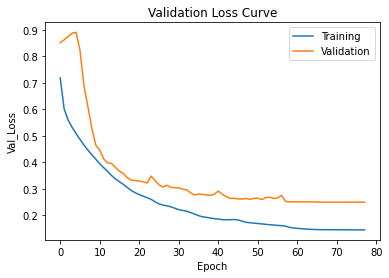

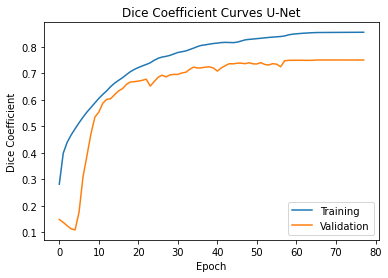

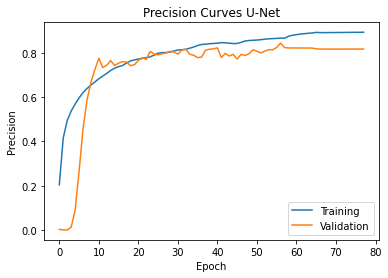

In [30]:
#accuracy dice coefficient precision graphs
import io
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

path = "/content/drive/MyDrive/DRIVE_Data/files/data.csv"
data_csv = pd.read_csv(path)
#data_csv

#shows how the val_loss decreases with each epoch

lines = data_csv.plot.line(x='epoch', y=['loss', 'val_loss'])
plt.title('Validation Loss Curve')
plt.ylabel('Val_Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

lines = data_csv.plot.line(x='epoch', y=['dice_coef', 'val_dice_coef'])
plt.title('Dice Coefficient Curves U-Net')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


lines = data_csv.plot.line(x='epoch', y=['precision_m', 'val_precision_m'])
plt.title('Precision Curves U-Net')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()
